<a href="https://colab.research.google.com/github/ErikLarssonDev/NLP/blob/main/Fine_tuning_llama2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuning for Llama 2 on Custom Dataset with QLoRA
The Llama 2 model will be fine-tuned using a supervised fine tuning with an instruction dataset.


## Dataset
The dataset that is used in this notebook is the [Open-Platypus dataset](https://huggingface.co/datasets/garage-bAInd/Open-Platypus), which is a combination of different datasets.

## Installing Dependencies

In [1]:
# Install Datasets library to load the dataset from hugging face into the Google Colab Notebook.
# Install Transformers library to import the Autotokenizer this will convert the raw text into tokens
# Install Sentence Transformers Library to download the Embedding Model
!pip install -q datasets transformers sentence_transformers faiss-gpu

## Set the Hugging Face Token
The HF_TOKEN can be set in the secrets tab in google colab.

In [2]:
from google.colab import userdata
# userdata.get('HF_TOKEN') # To check that the token can be fetched

## Load the Dataset

In [3]:
from datasets import load_dataset
dataset = load_dataset("garage-bAInd/Open-Platypus")
dataset

DatasetDict({
    train: Dataset({
        features: ['input', 'output', 'instruction', 'data_source'],
        num_rows: 24926
    })
})

In [4]:
dataset["train"]

Dataset({
    features: ['input', 'output', 'instruction', 'data_source'],
    num_rows: 24926
})

In [5]:
# Read the Dataset as the Pandas Dataset
dataset["train"].to_pandas()

,input,output,instruction,data_source
0,,To find the probability of the spinner landing...,A board game spinner is divided into three par...,MATH/PRM-800K
1,,"I need to choose 6 people out of 14, and the o...",My school's math club has 6 boys and 8 girls. ...,MATH/PRM-800K
2,,First we count the number of all 4-letter word...,How many 4-letter words with at least one cons...,MATH/PRM-800K
3,,She can do this if and only if at least one of...,Melinda will roll two standard six-sided dice ...,MATH/PRM-800K
4,,Think of the problem as a sequence of H's and ...,"Let $p$ be the probability that, in the proces...",MATH/PRM-800K
...,...,...,...,...
24921,,There are several formulas that generate all p...,Can we find a formula to generate all prime nu...,guanaco
24922,,"Sure, here are some of the best universities:\...",What are some of the best university's for stu...,guanaco
24923,,[Enter stage left]\n\nFirst Citizen: Good morr...,Write me a SPL (Shakespeare Programming Langua...,guanaco
24924,,That's a very thoughtful idea! Here are some s...,Hi. I want to make an embossed picture for my ...,guanaco


## Analyze the Dataset

In [6]:
#Use Transformers library to import the Autotokenizer this will convert the raw text into tokens
from transformers import AutoTokenizer
# Import Matplotlib and Seaborn Library to plot and visualize the data
import matplotlib.pyplot as plt
import seaborn as sns
# Next I will load the Tokenizer from Llama 2, I will use the Nous Research Version of Llama 2 and not the official one from meta,
# to use the official version of Llama 2 from meta you need to have an Hugging Face pro account
tokenizer = AutoTokenizer.from_pretrained("NousResearch/Llama-2-7b-hf")

In [7]:
#Tokenizer Downloaded
#Tokenize each row in the Instruction and Output Columns in the  Dataset and Count the Total Number of Tokens
instruction_tokens_count = [len(tokenizer.tokenize(example["instruction"])) for example in dataset["train"]]
# print("Instruction Tokens Count", instruction_tokens_count) # Long print
print("Length of Instruction Tokens Count", len(instruction_tokens_count))

Length of Instruction Tokens Count 24926


In [8]:
output_tokens_count = [len(tokenizer.tokenize(example["output"])) for example in dataset["train"]]
# print("Output Tokens Count", output_tokens_count) # Long print
print("Length of the Output Tokens Count", len(output_tokens_count))

Length of the Output Tokens Count 24926


In [9]:
#Combine the Instruction Token Count and the Output Token Count
combine_tokens_count = [instruction + output for instruction, output in zip(instruction_tokens_count, output_tokens_count)]
# print("Combine Tokens Count", combine_tokens_count) # Long print
print("Length of the Combine Tokens Count", len(combine_tokens_count))

Length of the Combine Tokens Count 24926


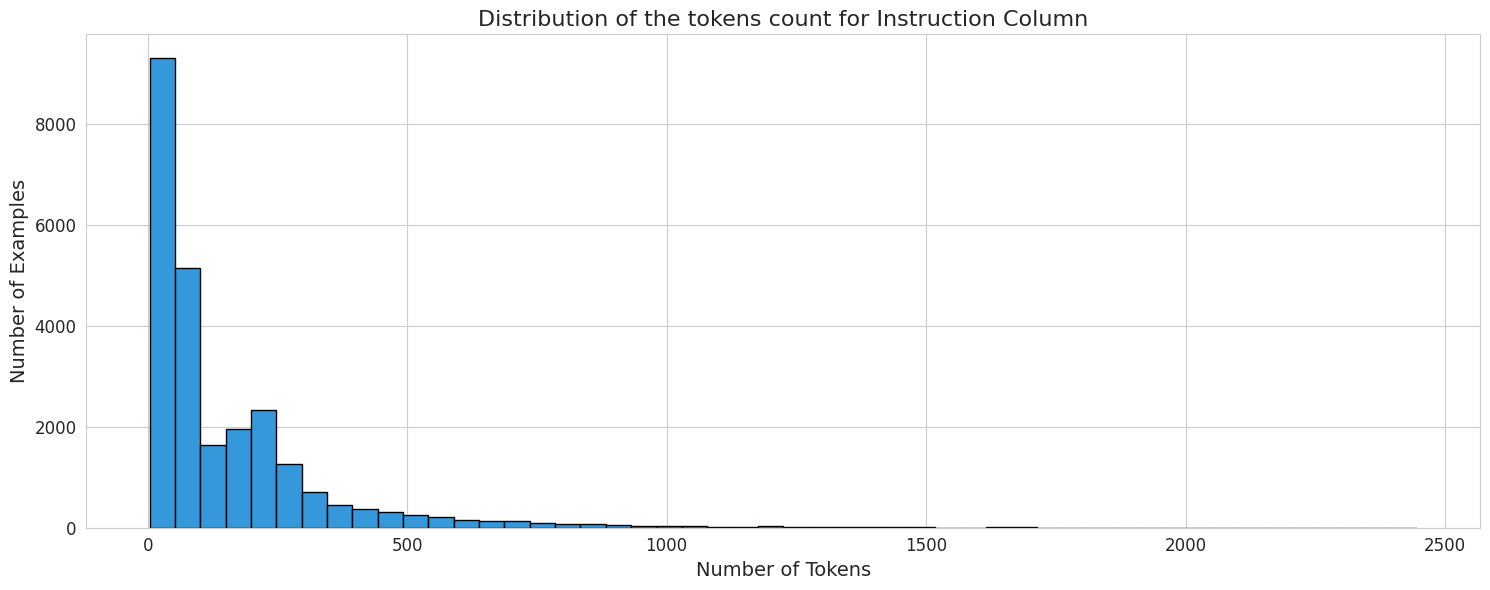

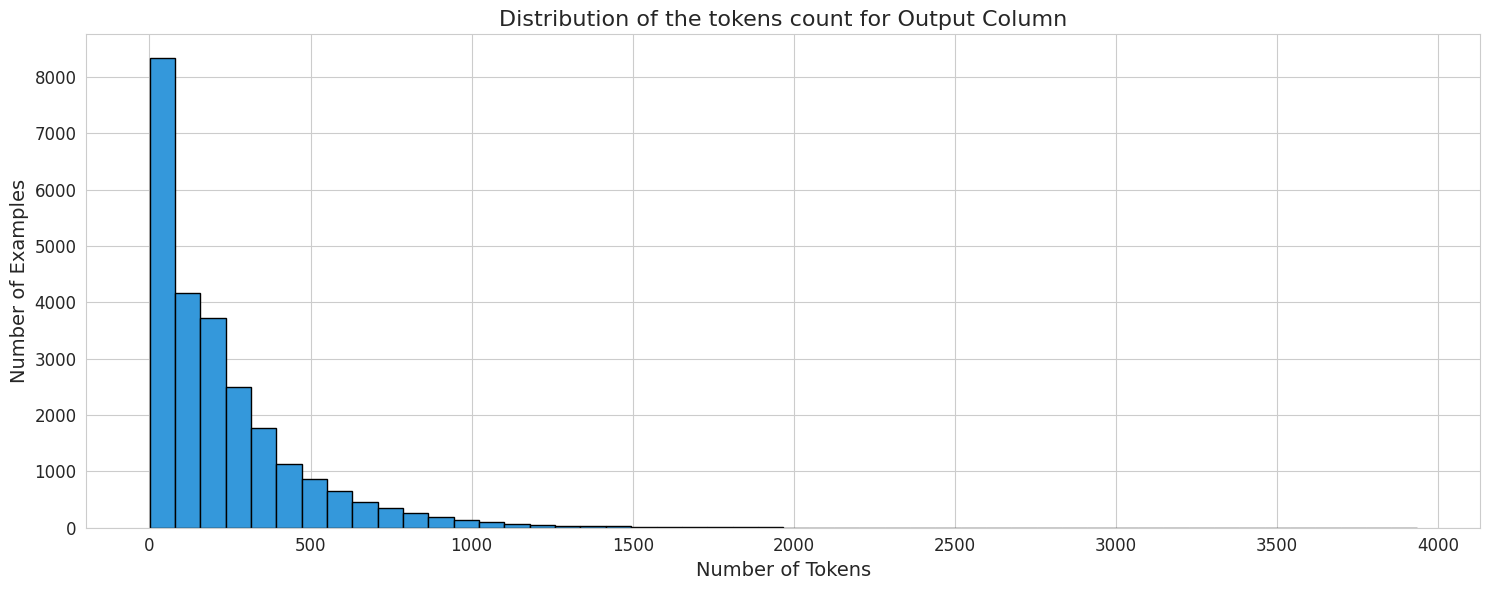

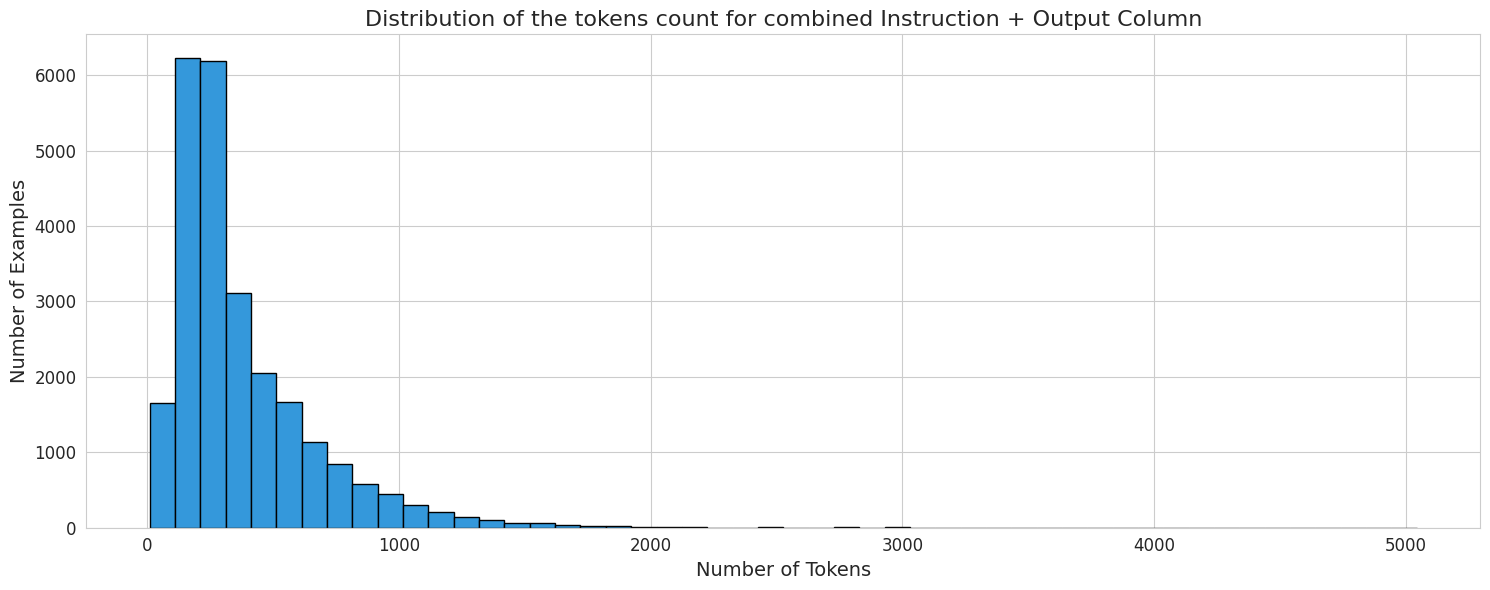

In [10]:
# Create a Histogram using the Matplotlib Library to see the distribution of the token counts
def plot_distribution(tokens_count, title):
  sns.set_style("whitegrid")
  plt.figure(figsize=(15, 6))
  plt.hist(tokens_count, bins=50, color='#3498db', edgecolor='black')
  plt.title(title, fontsize=16)
  plt.xlabel("Number of Tokens", fontsize=14)
  plt.ylabel("Number of Examples", fontsize=14)
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)
  plt.tight_layout()
  plt.show()

#Insruction Tokens Count
plot_distribution(instruction_tokens_count, "Distribution of the tokens count for Instruction Column")
#Output Tokens Count
plot_distribution(output_tokens_count, "Distribution of the tokens count for Output Column")
#Combine Tokens Count
plot_distribution(combine_tokens_count, "Distribution of the tokens count for combined Instruction + Output Column")
#The mean is around 500 tokens but there is a long tail distribution which goes up to 5000 tokens

## Filter out rows with more than 2048 tokens in the Combine Token Count (Instruction Column + Output Column)
 The Llama 2 and other LLMs, have a certain context window (input tokens limit)(Maximum Context Size of Llama 2 by default is 4096) and if the tokens goes beyond the this context window then it is not going to be helpful. So, its important to know the number of tokens in the dataset

Number of Valid Rows: 24895
Removing: 31 rows....


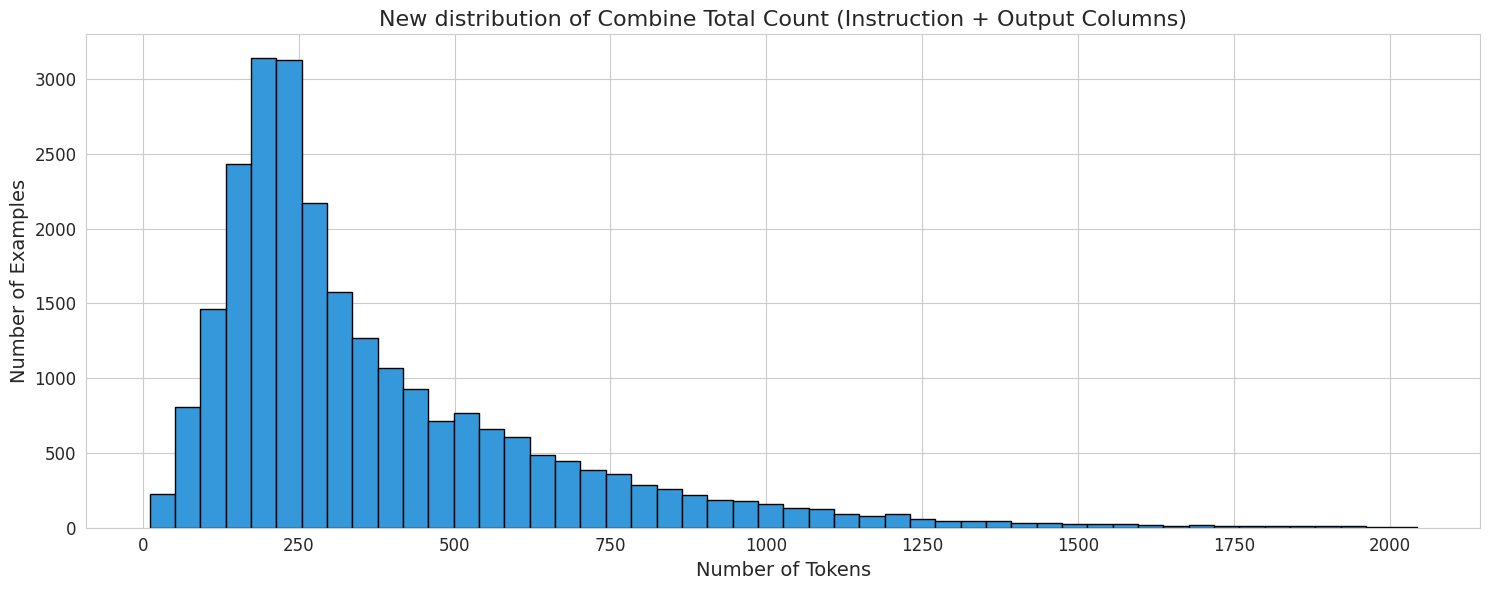

In [11]:
# Remove samples with more than 2048 tokens in the Combine Token Count
# First, filter  rows with less or equal to 2048 tokens
valid_indices = [i for i, count in enumerate(combine_tokens_count) if count <= 2048]
print(f"Number of Valid Rows: {len(valid_indices)}")
# Number of Rows with more than 2048 tokens
print(f"Removing: {len(dataset['train']) - len(valid_indices)} rows....")
# Second, extract valid rows based on indices
dataset['train'] = dataset['train'].select(valid_indices)

# Get token counts for valid rows
token_counts = [combine_tokens_count[i] for i in valid_indices]

plot_distribution(token_counts, "New distribution of Combine Total Count (Instruction + Output Columns)")

In [12]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input', 'output', 'instruction', 'data_source'],
        num_rows: 24895
    })
})

In [13]:
dataset["train"].to_pandas()

,input,output,instruction,data_source
0,,To find the probability of the spinner landing...,A board game spinner is divided into three par...,MATH/PRM-800K
1,,"I need to choose 6 people out of 14, and the o...",My school's math club has 6 boys and 8 girls. ...,MATH/PRM-800K
2,,First we count the number of all 4-letter word...,How many 4-letter words with at least one cons...,MATH/PRM-800K
3,,She can do this if and only if at least one of...,Melinda will roll two standard six-sided dice ...,MATH/PRM-800K
4,,Think of the problem as a sequence of H's and ...,"Let $p$ be the probability that, in the proces...",MATH/PRM-800K
...,...,...,...,...
24890,,There are several formulas that generate all p...,Can we find a formula to generate all prime nu...,guanaco
24891,,"Sure, here are some of the best universities:\...",What are some of the best university's for stu...,guanaco
24892,,[Enter stage left]\n\nFirst Citizen: Good morr...,Write me a SPL (Shakespeare Programming Langua...,guanaco
24893,,That's a very thoughtful idea! Here are some s...,Hi. I want to make an embossed picture for my ...,guanaco


## Near-Deduplication Using Embeddings
You can check the [MTEB leaderboard](https://huggingface.co/spaces/mteb/leaderboard) on Hugging face to choose the embedding model.

In [14]:
# In this notebook I am using the gte-large embedding model its not the best embedding model but it is fast
# I will use the sentence transformers library to download the embedding model
from sentence_transformers import SentenceTransformer
# Faiss will be used as our vector database which is not very fast but very simple to use
import faiss
from datasets import Dataset, DatasetDict
# tqdm creates a nice loading bar
from tqdm.autonotebook import tqdm
import numpy as np

def deduplicate_dataset(dataset: Dataset, model: str, threshold: float):
  # Here I will pass the name of the embedding model
  sentence_model = SentenceTransformer(model)
  # Embed every sample every row in the dataset output column
  outputs = [example["output"] for example in dataset["train"]]
  # Using the Embedding Model we will convert the text into embeddings
  print("Convert the text to embeddings....")
  embeddings = sentence_model.encode(outputs, show_progress_bar=True)
  dimensions = embeddings.shape[1]
  print("Dimensions of the embedding", embeddings.shape)
  # Create an index using the Faiss as our Vector Database
  index = faiss.IndexFlatIP(dimensions)
  # Normalize the Embeddings
  normalized_embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
  index.add(normalized_embeddings)
  print("Filtering out near duplicates....")
  # k=2, means atmost two vectors
  D, I = index.search(normalized_embeddings, k=2)
  # In the below list, we will add the list of samples we want to keep
  to_keep=[]
  # We will define the threshold below, if the embedding is 95% similar to other embedding then we will remove that embedding
  for i in tqdm(range(len(embeddings)), desc="Filtering"):
    # If the second closest vector (D[i,1]) has cosine similarity above the threshold
    if D[i,1] >= threshold:
      # Check if the current item or its nearest neighbor is already in the to_keep list
      nearest_neighbor = I[i,1]
      if i not in to_keep and nearest_neighbor not in to_keep:
        # If not, add the current item to the list
        to_keep.append(i)
    else:
        # If the similarity is below the threshold, always keep the current item
        to_keep.append(i)
  # print("List", to_keep) # Long print
  dataset = dataset["train"].select(to_keep)
  print(dataset.to_pandas())
  return DatasetDict({"train": dataset})

deduped_dataset = deduplicate_dataset(dataset, "thenlper/gte-large", 0.95)

Convert the text to embeddings....


Batches:   0%|          | 0/778 [00:00<?, ?it/s]

Dimensions of the embedding (24895, 1024)
Filtering out near duplicates....


Filtering:   0%|          | 0/24895 [00:00<?, ?it/s]

      input                                             output  \
0            To find the probability of the spinner landing...   
1            I need to choose 6 people out of 14, and the o...   
2            First we count the number of all 4-letter word...   
3            She can do this if and only if at least one of...   
4            Think of the problem as a sequence of H's and ...   
...     ...                                                ...   
18156        There are several formulas that generate all p...   
18157        Sure, here are some of the best universities:\...   
18158        [Enter stage left]\n\nFirst Citizen: Good morr...   
18159        That's a very thoughtful idea! Here are some s...   
18160        Certainly! Here's an implementation of the Tim...   

                                             instruction    data_source  
0      A board game spinner is divided into three par...  MATH/PRM-800K  
1      My school's math club has 6 boys and 8 girls. ...  M

In [15]:
deduped_dataset

DatasetDict({
    train: Dataset({
        features: ['input', 'output', 'instruction', 'data_source'],
        num_rows: 18161
    })
})

In [16]:
deduped_dataset["train"].to_pandas()

,input,output,instruction,data_source
0,,To find the probability of the spinner landing...,A board game spinner is divided into three par...,MATH/PRM-800K
1,,"I need to choose 6 people out of 14, and the o...",My school's math club has 6 boys and 8 girls. ...,MATH/PRM-800K
2,,First we count the number of all 4-letter word...,How many 4-letter words with at least one cons...,MATH/PRM-800K
3,,She can do this if and only if at least one of...,Melinda will roll two standard six-sided dice ...,MATH/PRM-800K
4,,Think of the problem as a sequence of H's and ...,"Let $p$ be the probability that, in the proces...",MATH/PRM-800K
...,...,...,...,...
18156,,There are several formulas that generate all p...,Can we find a formula to generate all prime nu...,guanaco
18157,,"Sure, here are some of the best universities:\...",What are some of the best university's for stu...,guanaco
18158,,[Enter stage left]\n\nFirst Citizen: Good morr...,Write me a SPL (Shakespeare Programming Langua...,guanaco
18159,,That's a very thoughtful idea! Here are some s...,Hi. I want to make an embossed picture for my ...,guanaco


In [17]:
print("Number of rows in the Original Dataset", (len(dataset["train"])))
print("Number of rows in the deduped dataset", (len(deduped_dataset["train"])))
print(f"Number of rows removed: {len(dataset['train']) - len(deduped_dataset['train'])}")

Number of rows in the Original Dataset 24895
Number of rows in the deduped dataset 18161
Number of rows removed: 6734


In [18]:
#Tokenize each row in the Instruction and Output Columns in the  Dataset and Count the Total Number of Tokens
instruction_tokens_count = [len(tokenizer.tokenize(example["instruction"])) for example in deduped_dataset["train"]]
# print("Instruction Tokens Count", instruction_tokens_count) # Long print
print("Length of Instruction Tokens Count", len(instruction_tokens_count))

output_tokens_count = [len(tokenizer.tokenize(example["output"])) for example in deduped_dataset["train"]]
# print("Output Tokens Count", output_tokens_count) # Long print
print("Length of the Output Tokens Count", len(output_tokens_count))

#Combine the Instruction Token Count and the Output Token Count
combine_tokens_count = [instruction + output for instruction, output in zip(instruction_tokens_count, output_tokens_count)]
# print("Combine Tokens Count", combine_tokens_count) # Long print
print("Length of the Combine Tokens Count", len(combine_tokens_count))

Length of Instruction Tokens Count 18161
Length of the Output Tokens Count 18161
Length of the Combine Tokens Count 18161


## Top K-Sampling
In Top K-Sampling I will separate the Top 1000 rows from the dataset based on the number of tokens. So as the daraset has 18,168 rows I will take those 1000 rows which have the most number of tokens

In [19]:
#Get the Top 1000 rows with most number of tokens
def get_top_k_rows(dataset, tokens_count, k):
  #Sort by descending token count and get the top 1000 rows
  sorted_indices = sorted(range(len(tokens_count)), key=lambda i: tokens_count[i], reverse=True)
  top_k_indices = sorted_indices[:k]
  # print("Top K Indices", top_k_indices) # Long print
  print("Length of Top K Indices", len(top_k_indices))

  #Extract the Top K rows
  top_k_data = {
      "instruction": [dataset["train"][i]["instruction"] for i in top_k_indices],
      "output": [dataset["train"][i]["output"] for i in top_k_indices]
  }
  return Dataset.from_dict(top_k_data)

k=1000
top_k_dataset = get_top_k_rows(deduped_dataset, combine_tokens_count, k)

Length of Top K Indices 1000


In [20]:
top_k_dataset

Dataset({
    features: ['instruction', 'output'],
    num_rows: 1000
})

In [21]:
dataset = DatasetDict({"train": top_k_dataset})

In [22]:
dataset

DatasetDict({
    train: Dataset({
        features: ['instruction', 'output'],
        num_rows: 1000
    })
})

In [23]:
dataset["train"].to_pandas()

,instruction,output
0,Let's come up with a rich and complex alien wo...,Planet Name: Xylothar\n\nXylothar is a diverse...
1,"Let\n$$p(x,y) = a_0 + a_1x + a_2y + a_3x^2 + a...","Observe that \begin{align*}\np(0,0) &= a_0 = ..."
2,"Given the code below, refactor it, add comment...",Here is the refactored and commented version:\...
3,Find the area of the region described by $x \g...,"Let $n = \lfloor x \rfloor,$ and let $\{x\} = ..."
4,Let $P$ be the plane passing through the origi...,Let $\mathbf{v} = \begin{pmatrix} x \\ y \\ z ...
...,...,...
995,Hello. My name is Mike. I have a message left ...,"Hello Mike, it's nice to meet you. As an AI la..."
996,"Given a prime $p$ and an integer $a$, we say t...","To find the primitive roots $\pmod 7$, I need ..."
997,Let $f$ be defined by \[f(x) = \left\{\n\begi...,The number $f^{-1}(-3)$ is the value of $x$ su...
998,"BEGININPUT\nBEGINCONTEXT\ndate: August 5, 2021...",Dr. Eleanor Thompson's study found that partic...


In [24]:
instruction_tokens_count = [len(tokenizer.tokenize(example["instruction"])) for example in dataset["train"]]
# print("Instruction Tokens Count", instruction_tokens_count)
print("Length of Instruction Tokens Count", len(instruction_tokens_count))


output_tokens_count = [len(tokenizer.tokenize(example["output"])) for example in dataset["train"]]
# print("Output Tokens Count", output_tokens_count)
print("Length of the Output Tokens Count", len(output_tokens_count))


# Combine the Instruction Token Count and the Output Token Count
combine_tokens_count = [instruction + output for instruction, output in zip(instruction_tokens_count, output_tokens_count)]
# print("Combine Tokens Count", combine_tokens_count)
print("Length of the Combine Tokens Count", len(combine_tokens_count))

Length of Instruction Tokens Count 1000
Length of the Output Tokens Count 1000
Length of the Combine Tokens Count 1000


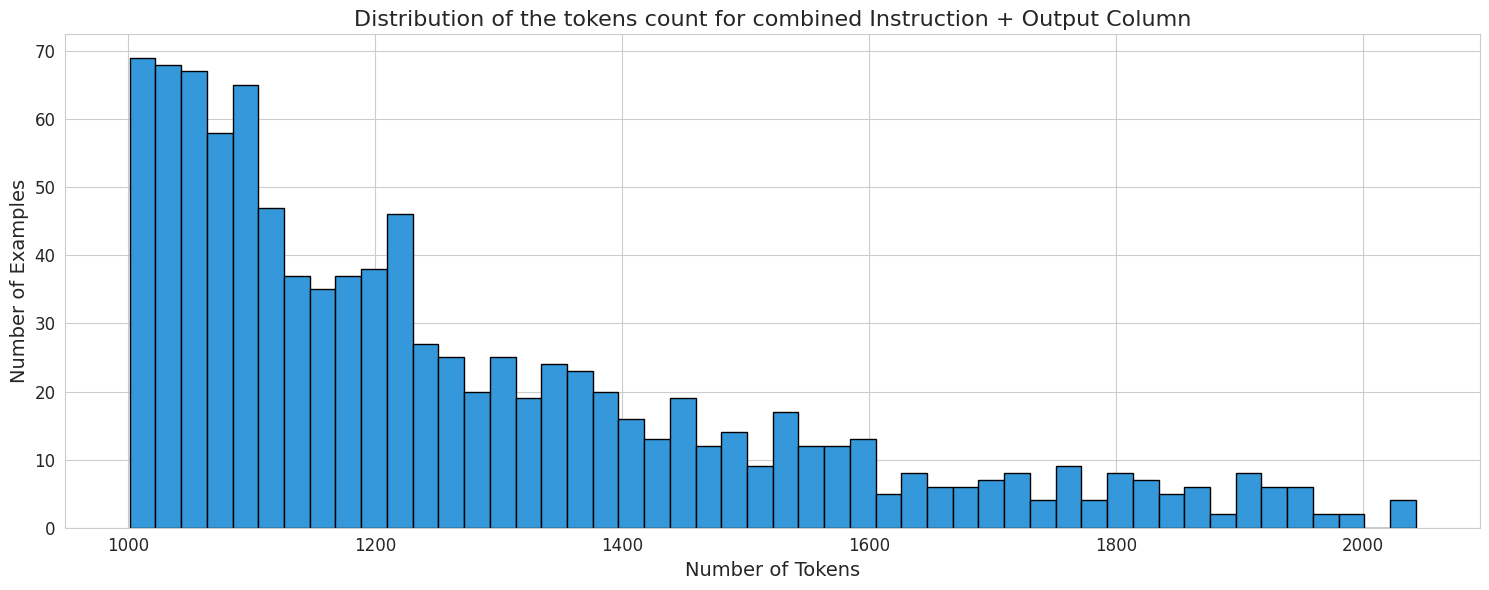

In [25]:
# Combine Tokens Count
plot_distribution(combine_tokens_count, "Distribution of the tokens count for combined Instruction + Output Column")

In [26]:
# Read as pandas DataFrame
dataset['train'].to_pandas()

,instruction,output
0,Let's come up with a rich and complex alien wo...,Planet Name: Xylothar\n\nXylothar is a diverse...
1,"Let\n$$p(x,y) = a_0 + a_1x + a_2y + a_3x^2 + a...","Observe that \begin{align*}\np(0,0) &= a_0 = ..."
2,"Given the code below, refactor it, add comment...",Here is the refactored and commented version:\...
3,Find the area of the region described by $x \g...,"Let $n = \lfloor x \rfloor,$ and let $\{x\} = ..."
4,Let $P$ be the plane passing through the origi...,Let $\mathbf{v} = \begin{pmatrix} x \\ y \\ z ...
...,...,...
995,Hello. My name is Mike. I have a message left ...,"Hello Mike, it's nice to meet you. As an AI la..."
996,"Given a prime $p$ and an integer $a$, we say t...","To find the primitive roots $\pmod 7$, I need ..."
997,Let $f$ be defined by \[f(x) = \left\{\n\begi...,The number $f^{-1}(-3)$ is the value of $x$ su...
998,"BEGININPUT\nBEGINCONTEXT\ndate: August 5, 2021...",Dr. Eleanor Thompson's study found that partic...


## Chat Templates
In the case of Llama 2, the authors used the following template for the chat models:

```html
<s>[INST] <<SYS>>
System prompt
<</SYS>>

User prompt [/INST] Model answer </s>
```


In [27]:
def chat_template(example):
    example["instruction"] = f"### Instruction:\n{example['instruction']}\n\n### Response:\n"
    return example

dataset = dataset.map(chat_template)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [28]:
dataset["train"].to_pandas()

,instruction,output
0,### Instruction:\nLet's come up with a rich an...,Planet Name: Xylothar\n\nXylothar is a diverse...
1,"### Instruction:\nLet\n$$p(x,y) = a_0 + a_1x +...","Observe that \begin{align*}\np(0,0) &= a_0 = ..."
2,"### Instruction:\nGiven the code below, refact...",Here is the refactored and commented version:\...
3,### Instruction:\nFind the area of the region ...,"Let $n = \lfloor x \rfloor,$ and let $\{x\} = ..."
4,### Instruction:\nLet $P$ be the plane passing...,Let $\mathbf{v} = \begin{pmatrix} x \\ y \\ z ...
...,...,...
995,### Instruction:\nHello. My name is Mike. I ha...,"Hello Mike, it's nice to meet you. As an AI la..."
996,### Instruction:\nGiven a prime $p$ and an int...,"To find the primitive roots $\pmod 7$, I need ..."
997,### Instruction:\nLet $f$ be defined by \[f(x...,The number $f^{-1}(-3)$ is the value of $x$ su...
998,### Instruction:\nBEGININPUT\nBEGINCONTEXT\nda...,Dr. Eleanor Thompson's study found that partic...


## Push the Dataset to Hugging Face Hub

In [31]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [46]:
dataset.push_to_hub("Larre/mini-platypus", token=userdata.get('HF_WRITE'))

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/Larre/mini-platypus/commit/fe7cf47921d6605f941512718d8f8f1e09f24f29', commit_message='Upload dataset', commit_description='', oid='fe7cf47921d6605f941512718d8f8f1e09f24f29', pr_url=None, pr_revision=None, pr_num=None)

## Fine-Tube Llama 2 Model
**There are two main fine-tuning techniques:**
1. Supervised fine-tuning (SFT)
2. Reinforcement Learning from Human Feedback (RLHF)

Supervised fine-tuning (SFT):
In Supervised Fine-Tuning the model is trained/fine-tuned on a dataset of instruction and responses. It adjusts the weights in the LLM to minimize the difference between the generated answers and ground truth responses, acting as labels.

**In this notebook, Supervised Fine-Tuning is performed.**

## Installing Dependencies

In [29]:
#install transformers library to import autotokenizer
#install datasets library to load the dataset from hugging face
#install peft library to fine-tune the Llama 2 model by reducing computational and memory requirements. PEFT methods only fine-tune a small number of (extra) model parameters
#install trl library to import SFT trainer, trl is a wrapper that can be for Supervised Fine Tuning or for Reinforcement Learning from Human Feedback
#install bitsandbytes library for quantization because we are not going to use the model in full precision
!pip install -q -U transformers datasets peft trl bitsandbytes
!pip install -q --upgrade accelerate einops xformers

In [30]:
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    pipeline,
)
from peft import LoraConfig, PeftModel, prepare_model_for_kbit_training
from trl import SFTTrainer

## Fine-Tune the Llama 2 model using Supervised Fine-Tuning (SFT)
There are three ways in which we can fine-tune the model using Supervised Fine-Tuning (SFT).

1. Full Fine-Tuning
2. LoRA
3. QLoRA

**Full Fine-Tuning:** With Full Fine-Tuning we are going to use the entire model, We will train all the weights in the model which is very costly.

**LoRA:** In LoRA instead of training all the weights, we will add some adapters in some layers and we will only train the added weights, which will reduce the cost of training the model because we are only training like 1% 2% of the entire weights

**QLoRA:** QLoRA which uses LoRA but here we use a model which has been quantized. If the LLM model is occupying 16bits on the disk, in QLoRA they will be quantized into 4bits so a lots of precision will be lose.

In this notebook, I am fine-tuning the Llama 2 model with 7 billion parameters, T4-GPU has 15GB of VRAM (GPU Memory) which is barely enough to store the Llama2-7b's weights (7b x 2bytes = 14GB in FP16). Plus we also need to consider the overhead due to optimizer states, gradients and forward activatons.

To reduce the VRAM usage (GPU Memory Usage) we will fine-tune the Llama 2 model in 4bit precision which is why we will use QLoRA here

In [47]:
# Model
base_model = "NousResearch/Llama-2-7b-chat-hf"
# Fine-tune model name
new_model = "llama-2-7b-platypus"
# Load the Dataset from hugging face
dataset = load_dataset("Larre/mini-platypus", split="train")
# Tokenizer
# Load the tokenizer from Llama 2
tokenizer = AutoTokenizer.from_pretrained(base_model, use_fast=True)
# In Llama2 we dont have the padding token which is a very big problem, because we have a dataset with different number of tokens in each row.
# So, we need to pad it so they all have the same length and here i am using end of sentence token and this will have an impact on the generation of our model
# I am using End of Sentence token for fine-tuning
tokenizer.pad_token=tokenizer.eos_token
tokenizer.padding_side="right"

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

In [48]:
dataset

Dataset({
    features: ['instruction', 'output'],
    num_rows: 1000
})

In [49]:
dataset.to_pandas()

,instruction,output
0,### Instruction:\nLet's come up with a rich an...,Planet Name: Xylothar\n\nXylothar is a diverse...
1,"### Instruction:\nLet\n$$p(x,y) = a_0 + a_1x +...","Observe that \begin{align*}\np(0,0) &= a_0 = ..."
2,"### Instruction:\nGiven the code below, refact...",Here is the refactored and commented version:\...
3,### Instruction:\nFind the area of the region ...,"Let $n = \lfloor x \rfloor,$ and let $\{x\} = ..."
4,### Instruction:\nLet $P$ be the plane passing...,Let $\mathbf{v} = \begin{pmatrix} x \\ y \\ z ...
...,...,...
995,### Instruction:\nHello. My name is Mike. I ha...,"Hello Mike, it's nice to meet you. As an AI la..."
996,### Instruction:\nGiven a prime $p$ and an int...,"To find the primitive roots $\pmod 7$, I need ..."
997,### Instruction:\nLet $f$ be defined by \[f(x...,The number $f^{-1}(-3)$ is the value of $x$ su...
998,### Instruction:\nBEGININPUT\nBEGINCONTEXT\nda...,Dr. Eleanor Thompson's study found that partic...


In [50]:
# Configration of QLoRA
# Quantization Configuration
# To reduce the VRAM usage we will load the model in 4 bit precision and we will do quantization
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    #Quant type
    #We will use the "nf4" format this was introduced in the QLoRA paper
    bnb_4bit_quant_type="nf4",
    #As the model weights are stored using 4 bits and when we want to compute its only going to use 16 bits so we have more accuracy
    bnb_4bit_compute_dtype=torch.float16,
    #Quantization parameters are quantized
    bnb_4bit_use_double_quant=True,
)


# LoRA configuration
peft_config = LoraConfig(
    # Alpha is the strength of the adapters. In LoRA, instead of training all the weights, we will add some adapters in some layers and we will only
    # train the added weights
    # We can merge these adapters in some layers in a very weak way using very low value of alpha (using very little weight) or using a high value of alpha
    # (using a big weight)
    # 15 is very big weight, usually 32 is considered as the standard value for this parameter
    lora_alpha=15,
    # 10% dropout
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM",
)

# Load base moodel
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    quantization_config=bnb_config,
    device_map={"": 0}
)

model.config.use_cache = False
model.config.pretraining_tp = 1

# Cast the layernorm in fp32, make output embedding layer require grads, add the upcasting of the lmhead to fp32
# prepare_model_for_kbit_training---> This function basically helps to built the best model possible
model = prepare_model_for_kbit_training(model)

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/179 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:397: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(


In [ ]:
# Set training arguments
training_arguments = TrainingArguments(
        output_dir="./results",
        num_train_epochs=1,# 3-5 good for the Llama 2 Model
        per_device_train_batch_size=4,# Number of batches that we are going to take for every step
        gradient_accumulation_steps=1,
        evaluation_strategy="steps",# Not helpful because we do not want to evaluate the model we just want to train it
        eval_steps=1000,
        logging_steps=25,
        optim="paged_adamw_8bit",# Adam Optimizer we will be using but a version that is paged and in 8 bits, so it will lose less memory
        learning_rate=2e-4,
        lr_scheduler_type="linear",
        warmup_steps=10,
        report_to="tensorboard",
        max_steps=-1, # if maximum steps=2, it will stop after two steps
)

# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    eval_dataset=dataset, # No separate evaluation dataset, i am using the same dataset
    peft_config=peft_config,
    dataset_text_field="instruction",
    max_seq_length=512, # In dataset creation we put a threshold 2k for context length (input token limit) but we dont have enough VRAM unfortunately it will take a lot of VRAM to put everything into memory so we are just gonna stop at 512
    tokenizer=tokenizer,
    args=training_arguments,
)

# Train model
trainer.train()

# Save trained model
trainer.model.save_pretrained(new_model)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss


In [ ]:
%load_ext tensorboard
%tensorboard --logdir results/runs

In [ ]:
# Run text generation pipeline with our model
# Input Prompt
prompt = "What is a large language model?"
# Wrap the prompt using the right chat template
instruction = f"### Instruction:\n{prompt}\n\n### Response:\n"
# Using Pipeline from the hugging face
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=128)
result = pipe(instruction)
# Trim the response, remove instruction manually
print(result[0]['generated_text'][len(instruction):])

**The response keeps repeating because of the padding technique, end of sentence token, If you dont want to see this behaviour please use a different padding technique.**

In [ ]:
# Empty VRAM
del model
del pipe
del trainer
import gc
gc.collect()
gc.collect()

## Merge the Base Model with the Trained Adapter

In [ ]:
# Reload model in FP16 and merge it with LoRA weights
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map={"": 0},
)
#Reload the Base Model and load the QLoRA adapters
model = PeftModel.from_pretrained(model, new_model)
model = model.merge_and_unload()

# Reload tokenizer to save it
tokenizer = AutoTokenizer.from_pretrained(base_model, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

## Push the Fine-Tuned Model and Tokenizer to the Hugging Face Hub

In [ ]:
#!huggingface-cli login
model.push_to_hub("Larre/llama-2-7b-platypus", check_pr=True, use_auth_token=userdata.get('HF_WRITE'))
tokenizer.push_to_hub("Larre/llama-2-7b-platypus", check_pr=True, use_auth_token=userdata.get('HF_WRITE'))